# Harmful Algal Bloom (HAB) Detection from Wyvern hyperspectral imagery

Exploratory Data Analysis (EDA) of Wyvern hyperspectral imagery captured with extended VNIR range (31 bands)

Pipeline steps include:

- Search and download scene from Spatiotemporal Asset Catalog (STAC)
- Scene visual preview (RGB) -> Geotiff
- Normalized Difference Water Index (NDWI) -> water mask -> GeoJSON, 2x Geotiff
- Normalized Difference Chlorophyll Index (NDCI) -> 2x Geotiff

## Wyvern Hyperspectral Band Information Table


Note: This table shows the electromagnetic spectrum transitions from visible light (approximately 400-700nm) into the
near-infrared region. The "Red Edge" represents the transition zone between visible red and NIR, which is particularly
important in vegetation analysis.

| Band ID | Wavelength (nm) | Color/Name |
|---------|----------------|------------|
| 1 | 445 | Dark Blue (Violet-Blue) |
| 2 | 464 | Blue |
| 3 | 480 | Light Blue |
| 4 | 490 | Cyan-Blue |
| 5 | 503 | Blue-Green |
| 6 | 510 | Cyan |
| 7 | 519 | Cyan-Green |
| 8 | 534 | Light Green |
| 9 | 550 | Green |
| 10 | 569 | Yellow-Green |
| 11 | 585 | Yellow |
| 12 | 600 | Yellow-Orange |
| 13 | 614 | Orange |
| 14 | 634 | Orange-Red |
| 15 | 650 | Red |
| 16 | 659 | Red |
| 17 | 669 | Dark Red |
| 18 | 679 | Deep Red |
| 19 | 689 | Far Red |
| 20 | 700 | Red Edge |
| 21 | 712 | Red Edge |
| 22 | 722 | Red Edge |
| 23 | 734 | Near Infrared (NIR) |
| 24 | 749 | Near Infrared (NIR) |
| 25 | 764 | Near Infrared (NIR) |
| 26 | 781 | Near Infrared (NIR) |
| 27 | 799 | Near Infrared (NIR) |
| 28 | 814 | Near Infrared (NIR) |
| 29 | 832 | Near Infrared (NIR) |
| 30 | 849 | Near Infrared (NIR) |
| 31 | 869 | Near Infrared (NIR) |

For more details see: `gdalinfo wyvern_dragonette-003_20241229T165203_12324bcb.tiff`.

## Band selection

Select appropriate bands for each raster product being generated.

### Visual preview in RGB

For creating an RGB visualization, the optimal band wavelengths to use are:

- Red: 650 nm (Band 15)
- Green: 550 nm (Band 9)
- Blue: 464 nm (Band 2)

These bands correspond to the typical wavelengths for red, green, and blue in the visible spectrum, providing a natural
color representation.

###  Normalized Difference Water Index (NDWI)

The original NDWI as proposed by McFeeters (1996) used the following bands:

- Green: ~550 nm
- NIR: ~820-860 nm (typically Landsat NIR band)

Band selection for this notebook's NDWI:

- Green: Band 9 (550 nm)
- Near Infrared (NIR): Band 30 (849 nm)

### Normalized Difference Chlorophyll Index (NDCI)

The NDCI is a simple alternative for detecting chlorophyll-a in water bodies.

Band selection for this notebook's NDCI:

- Red Edge: Band 21 (712 nm)
- Dark Red: Band 17 (669 nm)


## Install Python packages via pip

In [2]:
!pip install -q jupyter rasterio shapely geopandas matplotlib numpy requests ipyleaflet pillow geopandas

In [3]:
from io import BytesIO
from PIL import Image
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import requests
from ipyleaflet import Map, GeoJSON
import geopandas as gpd

## Search and download from Spatiotemporal Asset Catalog (STAC)

Wyvern's open data program is published at https://wyvern.space/open-data/

TODO: in a production pipeline, we would use pystac-client or another STAC SDK  to query the catalog and select an
appropriate scene of some area of interest (AOI) and time window.

### Define scene URLs

The Wyvern scenes are published as Cloud Optimized Geotiff (COG). We leverage that when reading the raster,
because GDAL and the rasterio package will fetch via http only the required bands, rather than the full scene.

For development and iteration on this notebook, however, it was much faster to download the .tiff files first, and 
read them from local disk.

In [3]:
# full scene raster geotiff
tampico_mx_url = "https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-003_20241229T165203_12324bcb/wyvern_dragonette-003_20241229T165203_12324bcb.tiff"
# data mask raster geotiff
tampico_mx_data_mask_url = "https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-003_20241229T165203_12324bcb/wyvern_dragonette-003_20241229T165203_12324bcb_data_mask.tiff"
# visual preview (rgb) in PNG
tampico_mx_overview_url = "https://wyvern-prod-public-open-data-program.s3.ca-central-1.amazonaws.com/wyvern_dragonette-003_20241229T165203_12324bcb/wyvern_dragonette-003_20241229T165203_12324bcb_preview.png"

## Visualize Wyvern preview image for this scene (PNG)

Take a look at Wyvern's visual preview. Note there does not appear to be any cloud cover! We'll compare that finding
with the data mask raster, below.

This preview is a not vibrant in appearance and because it is in PNG format it does not have any georeference data.
Below we'll create our own visual preview in Geotiff format.

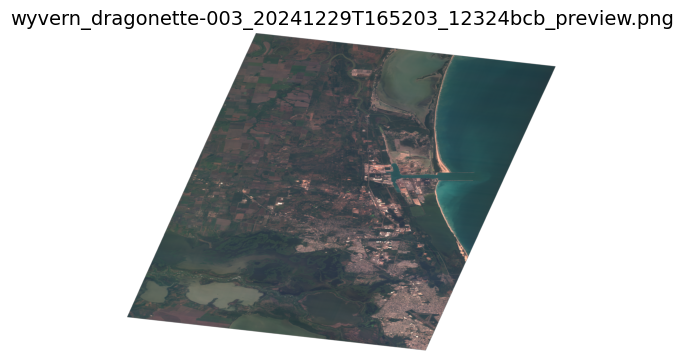

In [4]:
# Display the Wyvern preview image
response = requests.get(tampico_mx_overview_url)
img = Image.open(BytesIO(response.content))

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("wyvern_dragonette-003_20241229T165203_12324bcb_preview.png", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## Scene visual preview (RGB) -> Geotiff

The Wyvern-provided scene is not spatially referenced and it does not appear to have vibrant colors. We'll create a Geotiff using RGB bands.

## Read all the bands which will be used in the notebook

These bands are specifically selected from the 31 available bands in the Wyvern hyperspectral imagery (See Band
Selection above). Use Rasterio to read the bands into NumPy ndarrays.

In [5]:
with rio.open(tampico_mx_url) as src:

    # Blue 464nm for RGB preview
    band_blue_r464 = src.descriptions.index("Band_464")
    blue_r464 = src.read(band_blue_r464 + 1)

    # Green 550nm for NDWI and RGB preview
    band_green_r550 = src.descriptions.index("Band_550")
    green_r550 = src.read(band_green_r550 + 1)

    # Red 650nm for RGB preview
    band_red_r650 = src.descriptions.index("Band_650")
    red_r650 = src.read(band_red_r650 + 1)

    # Dark Red 669nm for NDCI
    band_red_r669 = src.descriptions.index("Band_669")
    red_r669 = src.read(band_red_r669 + 1)

    # Red Edge 712nm for NDCI
    band_red_edge_r712 = src.descriptions.index("Band_712")
    red_edge_r712 = src.read(band_red_edge_r712 + 1)

    # NIR 849nm for NDWI
    band_nir_r849 = src.descriptions.index("Band_849")
    nir_r849 = src.read(band_nir_r849 + 1)

    # save scene metadata
    src_meta = src.meta.copy()

    # confirm all the bands have same nodata value, so we can just use a common variable for all bands
    for i in range(0, 31):
        assert src.nodatavals[i] == src.nodatavals[0]

    # save nodata value
    nodata_val = src.nodatavals[0]

nodata_val

-9999.0

## Make validity masks using NODATA values

The scene is `float32` data type. We'll use `numpy.NaN` (not a number) for a validity mask, for simplicity.

In [6]:
blue_r464[blue_r464 == nodata_val] = np.nan
blue_r464_valid_mask = ~np.isnan(blue_r464)

green_r550[green_r550 == nodata_val] = np.nan
green_r550_valid_mask = ~np.isnan(green_r550)

red_r650[red_r650 == nodata_val] = np.nan
red_r650_valid_mask = ~np.isnan(red_r650)

red_r669[red_r669 == nodata_val] = np.nan
red_r669_valid_mask = ~np.isnan(red_r669)

red_edge_r712[red_edge_r712 == nodata_val] = np.nan
red_edge_r712_valid_mask = ~np.isnan(red_edge_r712)

nir_r849[nir_r849 == nodata_val] = np.nan
nir_r849_valid_mask = ~np.isnan(nir_r849)

## Make Visual (RGB) scene raster in Geotiff format

The use-case of this Geotiff is a visual preview for the web, therefore here are some requirements:

1. Convert the raster array from float32 to uint8.
2. Translate from geographic coordinates (EPSG:4326) to web mercator (EPSG:3857).

Well also tag the output geotiff filename as `L1B` because Level 1B is the Wyvern processing level:

> Image data which has been radiometrically processed to sensor units (at-sensor radiance, or top-of-atmosphere (TOA)
> radiance). Includes geolocation reference information and calibration parameters required to reach this level of
> processing. Source: [Wyvern Knowledge Center](https://knowledge.wyvern.space).


### Convert the raster array from float32 to uint8.

Using the 2nd and 98th percentiles for scaling is a common and conventional approach in image processing and remote sensing. This technique is known as "percentile-based contrast stretching" or "percentile normalization.". The benefits of this approach include:

1. Outlier reduction: By using the 2nd and 98th percentiles instead of min/max values, you avoid having your scaling dominated by extreme outliers (which might be noise or errors in the data)

2. Enhanced visual contrast: For visualization purposes, this creates better contrast in the main features of the data

3. Standard practice: This is a widely accepted practice in remote sensing and Earth observation data processing, particularly for Normalized Difference Indices (NDIs) like Normalized Difference Vegetation Index (NDVI) or Normalized Difference Water Index (NDWI)

This percentile-based approach is particularly useful for hyperspectral imagery where extreme values can be common due to sensor artifacts, atmospheric effects, or other anomalies.

(Source: Claude 3.7)

In [7]:
def scale_to_8bit(arr: np.ndarray, nodata_val: int = 0) -> np.ndarray:
    """
    Scale a numpy array to 8-bit (0-255) range using percentile-based contrast stretching.

    Parameters:
        arr (numpy.ndarray): Input array with potential NaN values
        nodata_val (int): Value to use for NaN areas in output (default: 0)
        
    Returns:
        numpy.ndarray: 8-bit unsigned integer array with NaN values replaced by nodata_val
    """
    # Create a copy to avoid modifying the input
    arr_copy = arr.copy()
    # Create a mask for valid values
    valid_mask = ~np.isnan(arr_copy)
    # Initialize output array with nodata value
    output = np.full_like(arr_copy, nodata_val, dtype=np.uint8)
    # Process only if we have valid data
    if np.any(valid_mask):
        # Calculate percentiles only on valid data
        min_val = np.nanpercentile(arr_copy, 2)  # 2nd percentile
        max_val = np.nanpercentile(arr_copy, 98)  # 98th percentile
        # Apply scaling only to valid data
        if max_val > min_val:  # Avoid division by zero
            if nodata_val == 0:
                # Scale to 1-255 range instead of 0-255
                scaled_valid = (arr_copy[valid_mask] - min_val) / (max_val - min_val) * 254 + 1
            else:
                scaled_valid = (arr_copy[valid_mask] - min_val) / (max_val - min_val) * 255
            scaled_valid = np.clip(scaled_valid, 1, 255)
            output[valid_mask] = scaled_valid.astype(np.uint8)
    return output

In [8]:
# Convert the raster arrays from float32 to uint8 and write out as geotiff

# Scale the RGB bands to 8-bit unsigned integer range
red_uint8 = scale_to_8bit(red_r650, 0)
green_uint8 = scale_to_8bit(green_r550, 0)
blue_uint8 = scale_to_8bit(blue_r464, 0)

# Stack the bands to create RGB image
# Make a copy of the input arrays to avoid modifying the originals
result_arr = np.stack([red_uint8, green_uint8, blue_uint8], axis=0)

# Reshape from scientific to image format (bands, height, width) -> (height, width, bands)
result_arr = np.transpose(result_arr, (1, 2, 0))

# re-use the metadata from the src, except update the datatype (uint8) and the nodata value (0).
dest_meta = src_meta.copy()
dest_meta.update(dict(
    dtype=result_arr.dtype,
    nodata=0,
    count=3,
))

with rio.open(
    "wyvern_dragonette-003_20241229T165203_12324bcb-L1B-viz.geotiff",
    "w",
    **dest_meta,
) as dst:
    for i in range(3):
        dst.write(result_arr[:, :, i], i+1)

### Convert to Geotiff

Prepare for publishing to Mapbox tileset, using their guidelines:

> - Only 8-bit GeoTIFFs are supported. Run gdalinfo to find your GeoTIFF's resolution.
> - Mapbox only accepts TIFFs with georeferencing information (GeoTIFFs). Make sure your TIFF is georeferenced before trying to upload.
> - Optimize your file by reprojecting to Web Mercator EPSG:3857. We recommend using gdalwarp for this.
> - Optimize your file by setting blocksize to 256x256, remove any alpha band if applicable, and use LZW for compression. We recommend using gdal_translate for this.


In [9]:
# run gdal cli for warp/transform and COG creation
!gdalwarp -t_srs EPSG:3857 -r bilinear -of GTiff -co COMPRESS=LZW -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 wyvern_dragonette-003_20241229T165203_12324bcb-L1B-viz.geotiff wyvern_dragonette-003_20241229T165203_12324bcb-L1B-viz-epsg-3857.geotiff

Creating output file that is 6411P x 9533L.
Using internal nodata values (e.g. 0) for image wyvern_dragonette-003_20241229T165203_12324bcb-L1B-viz.geotiff.
Copying nodata values from source wyvern_dragonette-003_20241229T165203_12324bcb-L1B-viz.geotiff to destination wyvern_dragonette-003_20241229T165203_12324bcb-L1B-viz-epsg-3857.geotiff.
Processing wyvern_dragonette-003_20241229T165203_12324bcb-L1B-viz.geotiff [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


### Preview in Geotiff RGB in notebook

Accomplished goals of 1) georeferenced preview image, and 2) more vibrant colors.

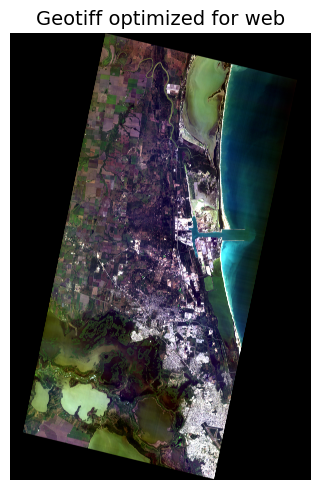

In [10]:
with rio.open("wyvern_dragonette-003_20241229T165203_12324bcb-L1B-viz-epsg-3857.geotiff") as l1b_src:
    l1b_image = np.transpose(l1b_src.read(), (1, 2, 0))  # Convert to (height, width, bands)

plt.figure(figsize=(5, 5))
plt.imshow(l1b_image)
plt.title("Geotiff optimized for web", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

## ⚠️ Architectural decision: surface level reflectance processing

We will not apply surface level reflectance processing in this pipeline. There are many options but they all require
fine tuning. Some examples are: ATCOR, 6S, iCOR, ACOLITE, SPy, HypPy, ENVI. It is acknowledged that this is a shortcut,
and for correctness, this pipeline should use Level 2A:

> Image data which has been atmospherically compensated/corrected to bottom-of-atmosphere (BOA) surface reflectance and
> orthorectified with digital elevation model (DEM) terrain correction. [Wyvern Knowledge
> Center](https://knowledge.wyvern.space/)


## Visualize "cloud" mask and "clear" QA masks

Are there clouds which need to be masked out? Wyvern provides a side-car QA raster (`*_data_mask.tiff`).

In [11]:
with rio.open(tampico_mx_data_mask_url) as src:
    band_cloud_mask = src.descriptions.index("QA_CLOUD_MASK")
    band_clear_mask =src.descriptions.index("QA_CLEAR_MASK")
    cloud_mask = src.read(band_cloud_mask + 1)
    clear_mask = src.read(band_clear_mask + 1)

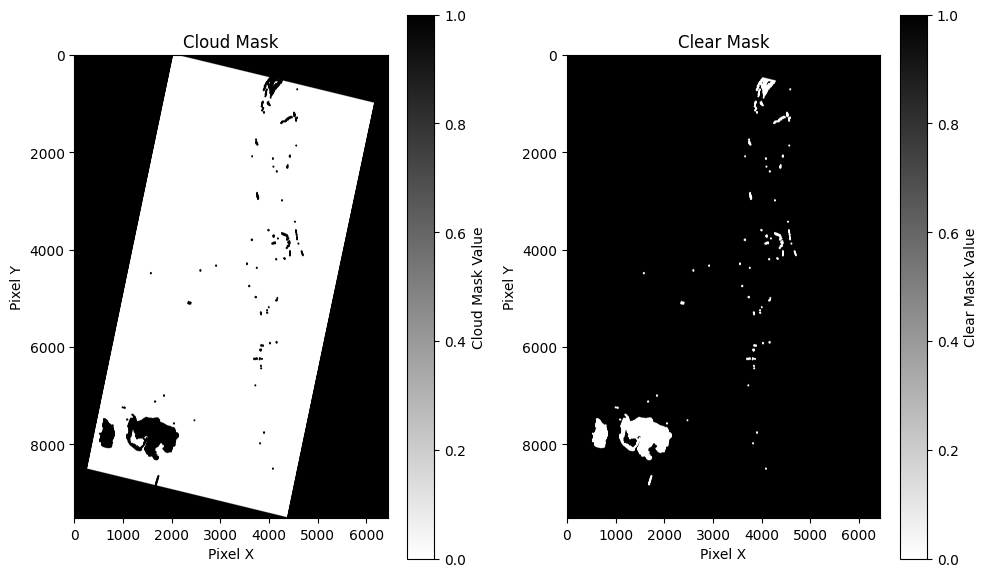

In [12]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(cloud_mask, cmap="binary", vmin=0, vmax=1)
plt.colorbar(label="Cloud Mask Value")
plt.title("Cloud Mask")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.subplot(1, 2, 2)
plt.imshow(clear_mask, cmap="binary", vmin=0, vmax=1)
plt.colorbar(label="Clear Mask Value")
plt.title("Clear Mask")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.show()

### ⚠️ Architectural decision: clear/cloud masks

We do not use the clear/cloud mask layers for this pipeline. They don't seem accurate, or I cannot interpret then. When
closely inspecting the preview image above, it definitely appears to be a cloud free scene.

## Normalized Difference Water Index (NDWI)

### Formula

$$NDWI = \frac{Green - NIR}{Green + NIR}$$

Where:
- **Green** = Band 9 (550 nm)
- **NIR** = Band 30 (849 nm)

### Range and interpretation

The range is [-1, 1] and interpretation is 1 = water and -1 = no water. Values closer to 1 indicate high probability of water, while values closer to -1 indicate non-water features like vegetation or dry soil. In typical applications:

- Values > 0.3: Usually indicate water bodies
- Values between 0 and 0.3: May indicate wet soil or mixed pixels
- Values < 0: Usually indicate vegetation or dry soil

### Visualize the NDWI bands (Green, NIR)

Preview of the raw reflectance before NDWI calculation. Note: there are negative values in the NIR (849nm).

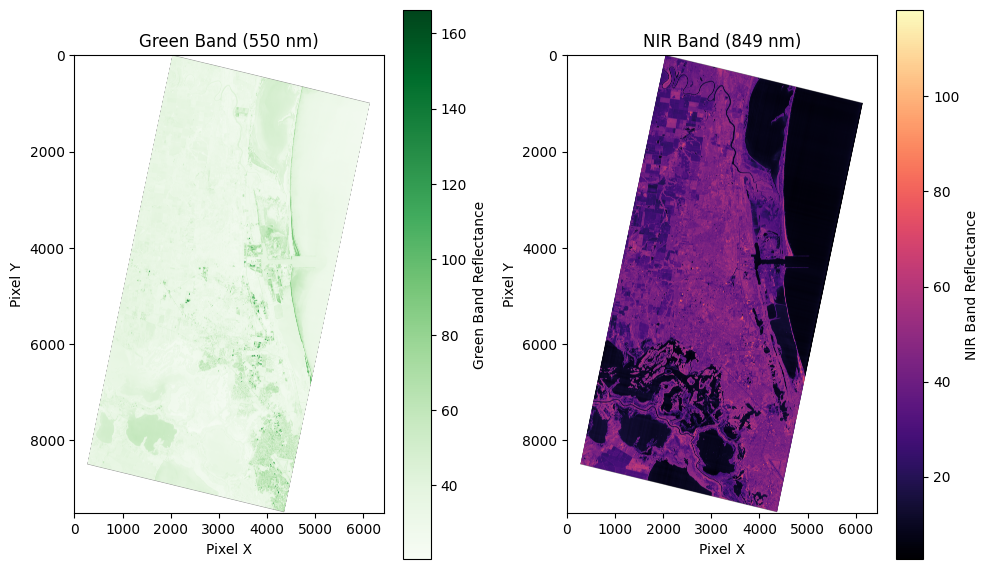

In [13]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(green_r550, cmap="Greens")
plt.colorbar(label="Green Band Reflectance")
plt.title("Green Band (550 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.subplot(1, 2, 2)
plt.imshow(nir_r849, cmap="magma")
plt.colorbar(label="NIR Band Reflectance")
plt.title("NIR Band (849 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.show()

### Make NDWI

In [14]:
valid_mask = green_r550_valid_mask & nir_r849_valid_mask
nir_r849_clamped = np.clip(nir_r849, 0, None)
ndwi = np.full_like(green_r550, np.nan)
ndwi[valid_mask] = (green_r550[valid_mask] - nir_r849_clamped[valid_mask]) / (green_r550[valid_mask] + nir_r849_clamped[valid_mask])

### Visualize NDWI raster

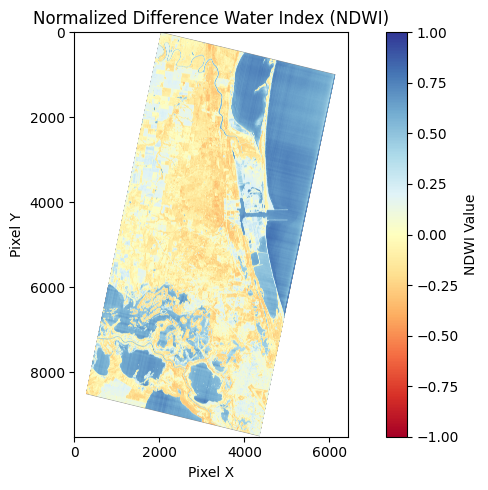

In [15]:
plt.figure(figsize=(8, 5))
plt.imshow(ndwi, cmap="RdYlBu", vmin=-1, vmax=1)
plt.colorbar(label="NDWI Value")
plt.title("Normalized Difference Water Index (NDWI)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

## Use NDWI to make a water mask raster with threshold value

By convention with NDWI, water is `> 0.3`.

In [16]:
water_threshold = 0.3
water_mask = np.zeros_like(ndwi, dtype=bool)
water_mask[valid_mask] = ndwi[valid_mask] > water_threshold

### Visualize water mask

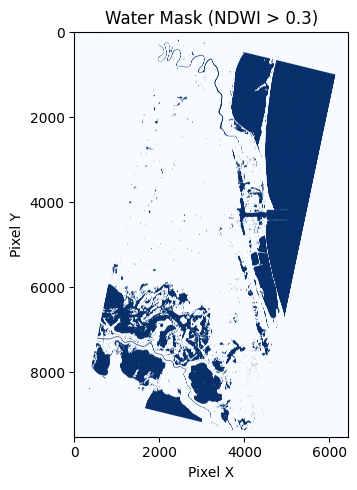

In [17]:
plt.figure(figsize=(5, 5))
plt.imshow(water_mask, cmap="Blues", vmin=0, vmax=1)
plt.title(f"Water Mask (NDWI > {water_threshold})")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

### Polygonize the water mask area

Write to GeoJSON file- it could be useful later in working with other location data (vector features).

In [18]:
results = (
    {"properties": {"value": v}, "geometry": s}
    for s, v in shapes(water_mask.astype(np.uint8), mask=water_mask, transform=src_meta["transform"])
)
geometries = [shape(result["geometry"]) for result in results if result["properties"]["value"] == 1]
gdf = gpd.GeoDataFrame(geometry=geometries, crs=src_meta["crs"])
gdf.to_file("wyvern_dragonette-003_20241229T165203_12324bcb-water-mask.geojson", driver="GeoJSON")

### Preview the GeoJSON in a Leaflet map

In [4]:
# Load the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file("wyvern_dragonette-003_20241229T165203_12324bcb-water-mask.geojson")

# Create a map centered on the GeoDataFrame"s centroid
# If gdf has multiple polygons, find the centroid of the whole collection
bbox = gdf.total_bounds
center = ((bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2)
map = Map(center=(center[1], center[0]), zoom=10)

# Add the GeoDataFrame as a GeoJSON layer
geo_json = GeoJSON(data=gdf.__geo_interface__)
map.add_layer(geo_json)

# Display the map
map

Map(center=[np.float64(22.464302212639232), np.float64(-97.92021035679693)], controls=(ZoomControl(options=['p…

### Make Geotiff raster for analysis (single band uint8)

In [20]:
with rio.open(
    "wyvern_dragonette-003_20241229T165203_12324bcb-water-mask.geotiff",
    "w",
    driver="GTiff",
    height=water_mask.shape[0],
    width=water_mask.shape[1],
    count=1,
    dtype="uint8",
    crs=src_meta["crs"],
    transform=src_meta["transform"],
    compress="lzw",
) as dst:
    dst.write(water_mask.astype("uint8"), 1)

### Make Geotiff raster for visualization (3 bands RGB, web-ready)

In [21]:
water_mask_rgb = np.zeros((3, water_mask.shape[0], water_mask.shape[1]), dtype=np.uint8)

# Set water pixels to blue-ish (1,1,255). Note: don't use 0 because that's the nodata value.
water_mask_rgb[0, water_mask] = 1
water_mask_rgb[1, water_mask] = 1
water_mask_rgb[2, water_mask] = 255

# Write the RGB water mask to a Geotiff
with rio.open(
    "wyvern_dragonette-003_20241229T165203_12324bcb-water-mask-viz.geotiff",
    "w",
    driver="GTiff",
    height=water_mask.shape[0],
    width=water_mask.shape[1],
    count=3,
    dtype="uint8",
    crs=src_meta["crs"],
    transform=src_meta["transform"],
    compress="lzw",
    photometric="RGB",
    nodata=0,
) as dst:
    for i in range(3):
        dst.write(water_mask_rgb[i, :, :], i + 1)

### Reproject for web

Use GDAL to warp water mask geotiff to web mercator (EPSG:3857).


In [22]:
!gdalwarp -t_srs EPSG:3857 -r bilinear -of GTiff -co COMPRESS=LZW -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 wyvern_dragonette-003_20241229T165203_12324bcb-water-mask-viz.geotiff wyvern_dragonette-003_20241229T165203_12324bcb-water-mask-viz-epsg-3857.geotiff

Creating output file that is 6411P x 9533L.
Using internal nodata values (e.g. 0) for image wyvern_dragonette-003_20241229T165203_12324bcb-water-mask-viz.geotiff.
Copying nodata values from source wyvern_dragonette-003_20241229T165203_12324bcb-water-mask-viz.geotiff to destination wyvern_dragonette-003_20241229T165203_12324bcb-water-mask-viz-epsg-3857.geotiff.
Processing wyvern_dragonette-003_20241229T165203_12324bcb-water-mask-viz.geotiff [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


## Normalized Difference Chlorophyll Index (NDCI)

NDCI is a simple alternative for detecting chlorophyll-a in water bodies.

### Formula

$$NDCI = \frac{RedEdge - Red}{RedEdge + Red}$$

Where
- **RedEdge** = Band 21 (712 nm)
- **Red** = Band 17 (669 nm)

### Range and interpretation

The range is [-1, 1] and the interpretation is:

- Higher positive values indicate higher chlorophyll-a concentration
- Values near zero suggest low chlorophyll-a levels
- Typical range is approximately -0.1 to +0.3 for most inland waters

### Visualize the NDCI bands (Dark Red, Red Edge)

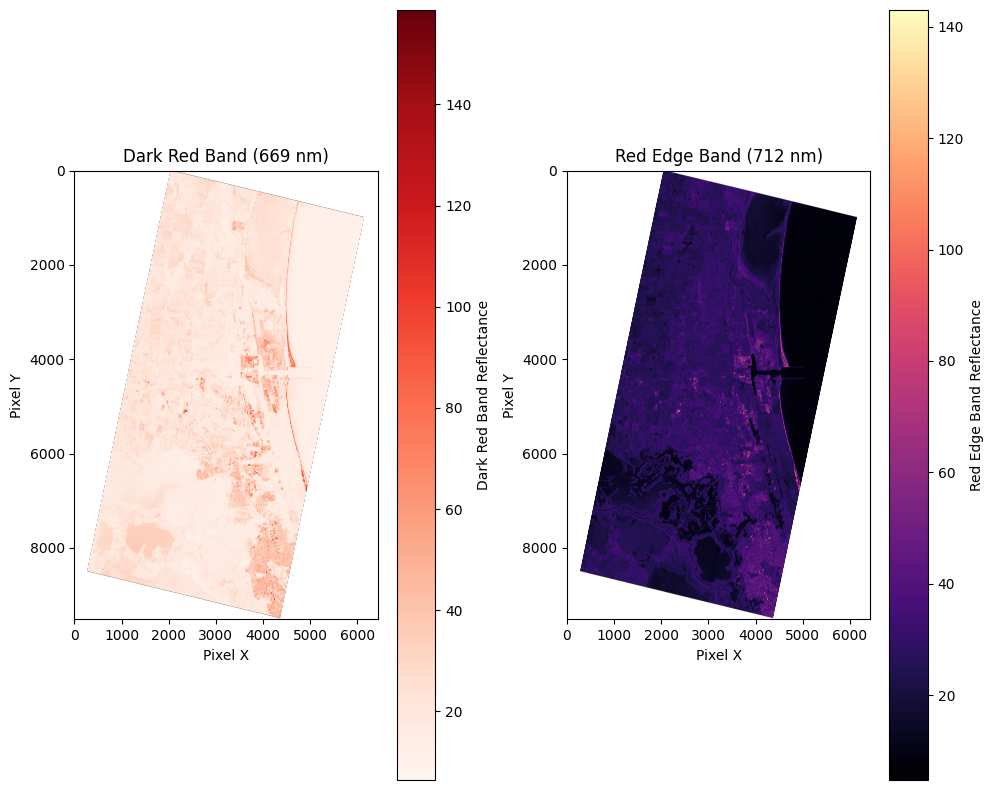

In [23]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(red_r669, cmap="Reds")
plt.colorbar(label="Dark Red Band Reflectance")
plt.title("Dark Red Band (669 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.subplot(1, 2, 2)
plt.imshow(red_edge_r712, cmap="magma")
plt.colorbar(label="Red Edge Band Reflectance")
plt.title("Red Edge Band (712 nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.show()

### Make NDCI

In [24]:
# calculate NDCI formula
red_edge_r712_clamped = np.clip(red_edge_r712, 0, None)
valid_mask = red_edge_r712_valid_mask & red_r669_valid_mask & water_mask
ndci = np.full_like(red_r669, np.nan)
ndci[valid_mask] = (red_edge_r712_clamped[valid_mask] - red_r669[valid_mask]) / (red_edge_r712_clamped[valid_mask] + red_r669[valid_mask])

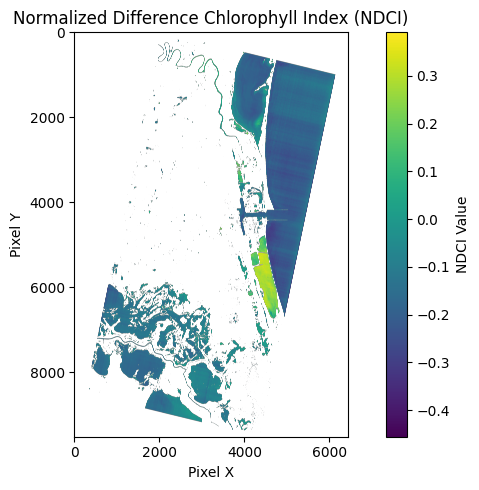

In [25]:
plt.figure(figsize=(8, 5))
plt.imshow(ndci, cmap="viridis")
plt.colorbar(label="NDCI Value")
plt.title("Normalized Difference Chlorophyll Index (NDCI)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.tight_layout()
plt.show()

### Make Geotiff raster for analysis (single-band float32)

In [26]:
with rio.open(
    "wyvern_dragonette-003_20241229T165203_12324bcb-NDCI.geotiff",
    "w",
    driver="GTiff",
    height=ndci.shape[0],
    width=ndci.shape[1],
    count=1,
    dtype="float32",
    crs=src_meta["crs"],
    transform=src_meta["transform"],
    compress="lzw",
) as dst:
    dst.write(ndci.astype("float32"), 1)

### Make Geotiff for visualization (RGB, web-ready)

In [27]:
# Normalize the NDCI values to the range [0, 1] for the colormap
ndci_normalized = np.full_like(ndci, np.nan)
valid_ndci_mask = ~np.isnan(ndci)
ndci_min, ndci_max = -1, 0.3
ndci_normalized[valid_ndci_mask] = (ndci[valid_ndci_mask] - ndci_min) / (ndci_max - ndci_min)
ndci_normalized = np.clip(ndci_normalized, 0, 1)

# Map the normalized NDCI values to RGB using the viridis colormap
viridis_cmap = matplotlib.colormaps["viridis"]
ndci_rgb = np.full((3, ndci.shape[0], ndci.shape[1]), 0, dtype=np.uint8)
ndci_rgb[:, valid_ndci_mask] = (viridis_cmap(ndci_normalized[valid_ndci_mask])[:, :3] * 255).T.astype(np.uint8)

# Write the RGB NDCI raster to a Geotiff
with rio.open(
    "wyvern_dragonette-003_20241229T165203_12324bcb-NDCI-viz.geotiff",
    "w",
    driver="GTiff",
    height=ndci.shape[0],
    width=ndci.shape[1],
    count=3,
    dtype="uint8",
    crs=src_meta["crs"],
    transform=src_meta["transform"],
    compress="lzw",
    photometric="RGB",
    nodata=0,
) as dst:
    for i in range(3):
        dst.write(ndci_rgb[i, :, :], i + 1)

### Reproject for web

Warp water mask geotiff to web mercator (EPSG:3857)

In [28]:
!gdalwarp -t_srs EPSG:3857 -r bilinear -of GTiff -co COMPRESS=LZW -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 wyvern_dragonette-003_20241229T165203_12324bcb-NDCI-viz.geotiff wyvern_dragonette-003_20241229T165203_12324bcb-NDCI-viz-web-epsg-3857.geotiff

Creating output file that is 6411P x 9533L.
Using internal nodata values (e.g. 0) for image wyvern_dragonette-003_20241229T165203_12324bcb-NDCI-viz.geotiff.
Copying nodata values from source wyvern_dragonette-003_20241229T165203_12324bcb-NDCI-viz.geotiff to destination wyvern_dragonette-003_20241229T165203_12324bcb-NDCI-viz-web-epsg-3857.geotiff.
Processing wyvern_dragonette-003_20241229T165203_12324bcb-NDCI-viz.geotiff [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Finished with exploratory data analysis!